In [214]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits 
import glob as g 
!pip install import-ipynb
import import_ipynb
import supplemental_functions as sf
from astropy.modeling.functional_models import Gaussian2D
from scipy.optimize import curve_fit

In [261]:
def opening_fits(filename):
    '''
    Parameters--
    filename: the path to the fits file 
                that is going to be opened
    Returns--
    data: the image/data that will be used
            for analysis 
    header: the information that is not the 
            image itself
    '''
    foo = fits.open(filename)
    data = foo[0].data
    header = foo[0].header
    foo.close()

    return data, header

In [262]:
def finding_peaks(image, threshold):
    '''
    Parameters--
    image: array-like, the image of the star
    threshold: number, the minimum number of 
                counts to include 
    Returns--
    peaks: array-like, the coordinates of each peak 
            detected above the threshold
    '''
    peaks = sf.findpeaks_maxfilter(image, threshold)
    return peaks 

In [263]:
def find_centroid(image, peak_x, peak_y, window=10):
    '''
    Parameters--
    image: array-like, the image of the star
    peak_x: int, x position of peak 
    peak_y: int, y position of peak
    window: int, optional 
            default=10
    Returns--
    centroid_x: float, x location of center point 
                sub-pixel precision
    centroid_y: float, y location of center point 
                sub-pixel precision 
    image_cutout: array-like, part of image surrounding 
                  centroid location
    '''
    ndim = image.shape
    boxwidth = int(window/2)

    if (peak_x - boxwidth <= 0 or 
        peak_x + boxwidth >= ndim[1] or 
        peak_y - boxwidth <= 0 or 
        peak_y + boxwidth >= ndim[0]):
        raise AssertionError('Peak too close to edge. Try a smaller window or skip')

    xx, yy = np.meshgrid(np.arange(peak_x - boxwidth, peak_x + boxwidth), 
                         np.arange(peak_y - boxwidth, peak_y + boxwidth))
    image_cutout = image[peak_x - boxwidth: peak_x + boxwidth, peak_y - boxwidth: peak_y + boxwidth]

    flux_sum = np.sum(image_cutout)
    centroid_x = np.sum(xx * image_cutout) / flux_sum
    centroid_y = np.sum(yy * image_cutout) / flux_sum

    return centroid_x, centroid_y, image_cutout
    

In [264]:
def find_moment(image, peak_x, peak_y, centroid_x, centroid_y, window=10):
    '''
    Parameters--
    image: array-like, the image of the star
    peak_x: int, x position of peak 
    peak_y: int, y position of peak
    centroid_x: float, x location of center point 
                sub-pixel precision
    centroid_y: float, y location of center point 
                sub-pixel precision 
    window: int, optional 
            default=10
    Returns--
    sigma_x: float, width of error in x direction
    sigma_y: float, width of error in y direction 
    '''
    boxwidth = int(window/2)
    
    xx, yy = np.meshgrid(np.arange(peak_x - boxwidth, peak_x + boxwidth), 
                         np.arange(peak_y - boxwidth, peak_y + boxwidth))
    image_cutout = image[peak_x - boxwidth: peak_x + boxwidth, peak_y - boxwidth: peak_y + boxwidth]

    flux_sum = np.sum(image_cutout)
    x_sq = np.sum((xx ** 2) * image_cutout) / flux_sum
    y_sq = np.sum((yy ** 2) * image_cutout) / flux_sum
    sigma_x = np.sqrt(x_sq - (centroid_x**2))
    sigma_y = np.sqrt(y_sq - (centroid_y**2))

    return sigma_x, sigma_y
    

In [265]:
def phot(image, peak_x, peak_y, centroid_x, centroid_y, sigma_x, sigma_y, window=10):
    '''
    Parameters--
    image: array-like, the image of the star
    peak_x: int, x position of peak 
    peak_y: int, y position of peak
    centroid_x: float, x location of center point 
                sub-pixel precision
    centroid_y: float, y location of center point 
                sub-pixel precision 
    sigma_x: float, width of error in x direction
    sigma_y: float, width of error in y direction 
    window: int, optional 
            default=10
    Returns--
    model: array-like, normalized gaussian fit 
    psf_convolve: array-like, counts from 
                  multiplied model and cutout
    psf_flux: float, sum of psf_convolve
    image_cutout: array-like, part of image surrounding 
                  centroid location
    gauss_fit: array-like, not normalized 
    window: value given
    '''
    boxwidth = int(window/2)

    xx, yy = np.meshgrid(np.arange(peak_x - boxwidth, peak_x + boxwidth), 
                         np.arange(peak_y - boxwidth, peak_y + boxwidth))
    image_cutout = image[peak_x - boxwidth: peak_x + boxwidth, peak_y - boxwidth: peak_y + boxwidth]

    #gauss = Gaussian2D(x_mean=centroid_x, y_mean=centroid_y, x_stddev=sigma_x, y_stddev=sigma_y)
    #gauss_fit = gauss(xx, yy)

    x_num  = (xx - centroid_x) ** 2
    y_num  = (yy - centroid_y) ** 2
    
    xdenom = 2*(sigma_x**2)
    ydenom = 2*(sigma_y**2)
    
    gauss_fit = np.exp(- ((x_num / xdenom) + (y_num / ydenom)))
    model = gauss_fit / np.sum(gauss_fit)
    psf_convolve = model * image_cutout
    psf_flux = np.sum(psf_convolve)

    return model, psf_convolve, psf_flux, image_cutout, gauss_fit, window

In [87]:
science_g = 'GSC_zg_filter_unzipped.fits'
data_science_g, header_science_g = opening_fits(science_g)

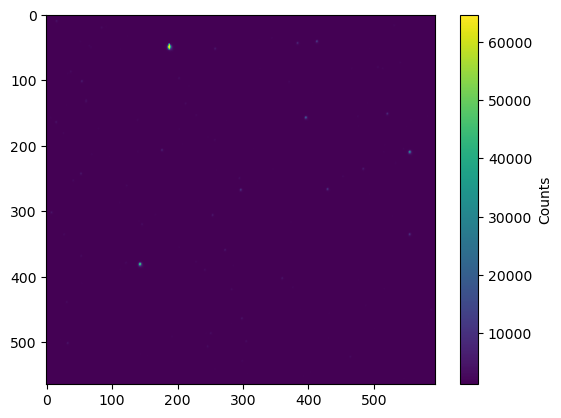

In [88]:
plt.imshow(data_science_g)
plt.colorbar(label='Counts')
plt.show()

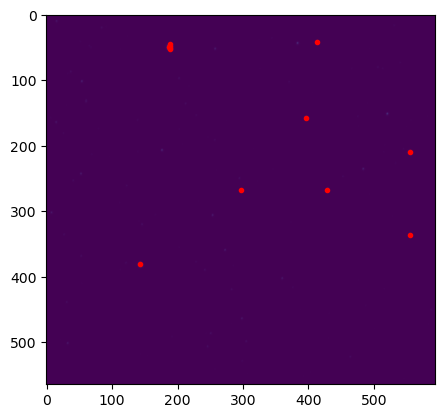

In [236]:
peaks_sci_g = finding_peaks(data_science_g, 10000)

plt.imshow(data_science_g,)
plt.plot(peaks_sci_g[:, 1], peaks_sci_g[:, 0], 'r.')

In [237]:
peaks_sci_g

array([[ 41, 413],
       [ 45, 188],
       [ 47, 188],
       [ 49, 187],
       [ 50, 189],
       [ 52, 188],
       [157, 396],
       [210, 555],
       [267, 429],
       [268, 297],
       [336, 555],
       [381, 143]], dtype=int64)

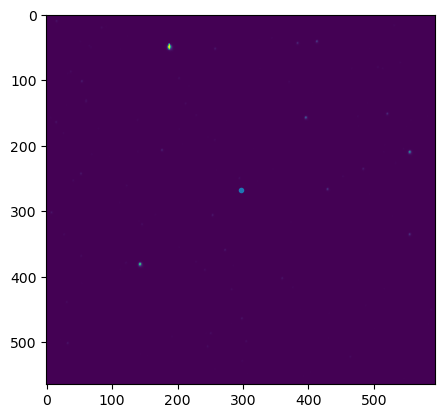

In [238]:
centx_sci_g, centy_sci_g, image_cutout = find_centroid(data_science_g, 268, 297)

plt.imshow(data_science_g)
plt.plot(centy_sci_g, centx_sci_g, '.') ##x and y are flipped for some reason
#plt.imshow(image_cutout)

In [239]:
sigmax_sci_g, sigmay_sci_g = find_moment(data_science_g, 268, 297, centx_sci_g, centy_sci_g)

print(sigmax_sci_g, sigmay_sci_g)

2.3656266197983578 2.4087294441405107


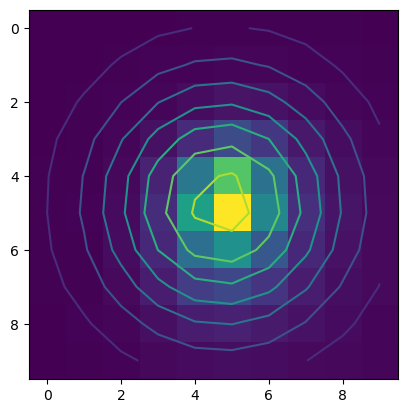

In [254]:
model_sci_g, convolve_sci_g, flux_sci_g, cutout_g, gauss_g, window_g = phot(data_science_g, 268, 297, centx_sci_g, centy_sci_g, sigmax_sci_g, sigmay_sci_g, window=10)

plt.imshow(cutout_g)
plt.contour(model_sci_g)

In [118]:
all_stars = ['Fiege_zg_filter_unzipped.fits', 'SA113-466_zg_filter_unzipped.fits', 'SA115-420_zg_filter_unzipped.fits',
             'BD750325_zg_filter_unzipped.fits', 'Ross_zg_filter_unzipped.fits', 'GSC_zg_filter_unzipped.fits', 
             'GSC_zr_filter_unzipped.fits']

data_list = []
header_list = []

for star in all_stars:
    data, header = opening_fits(star)
    data_list.append(data)
    header_list.append(header)

In [207]:
airmasses = np.array([])
gain = np.array([])
read_noise = np.array([])
exposure_time = np.array([])

for i in range(len(header_list)):
    airmasses = np.append(airmasses, header_list[i]['AIRMASS'])
    gain = np.append(gain, header_list[i]['GAIN'])
    read_noise = np.append(read_noise, header_list[i]['READNOI'])
    exposure_time = np.append(exposure_time, header_list[i]['EXPOSURE'])

avg_gain = np.mean(gain)
avg_noise = np.mean(read_noise)

avg_gain, avg_noise

(6.242857142857143, 9.671428571428573)

(13.621575917348132,
 2354.6678666518637,
 3288.23781934212,
 933.5699526902561,
 10,
 9.33569952690256,
 100)

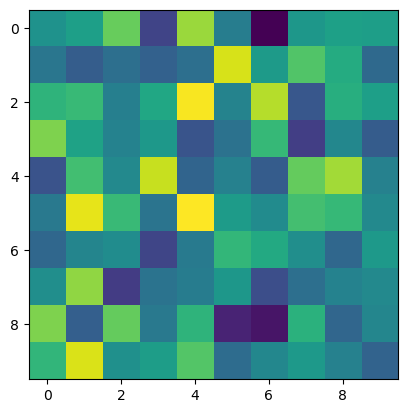

In [255]:
empty_sky = data_science_g[400 - int(window_g/2): 400 + int(window_g/2), 400 - int(window_g/2): 400 + int(window_g/2)]
empty__x, empty_y = np.meshgrid(np.arange(400 - int(window_g/2), 400 + int(window_g/2)), 
                                np.arange(400 - int(window_g/2), 400 + int(window_g/2)))

empty_convolve = empty_sky * model_sci_g
n_sky = np.median(empty_convolve)
n_pixels = window_g ** 2
n_tot_sky = n_sky * n_pixels
n_net_star = flux_sci_g - n_tot_sky

plt.imshow(empty_sky)
snr = n_net_star / (np.sqrt((avg_gain * n_net_star) + (n_pixels * avg_gain * n_sky) + (n_pixels * (avg_noise**2))))
snr, n_net_star, flux_sci_g, n_tot_sky, window_g, n_sky, n_pixels

Text(0.5, 1.0, 'Growth Curve Based on Window Sizes')

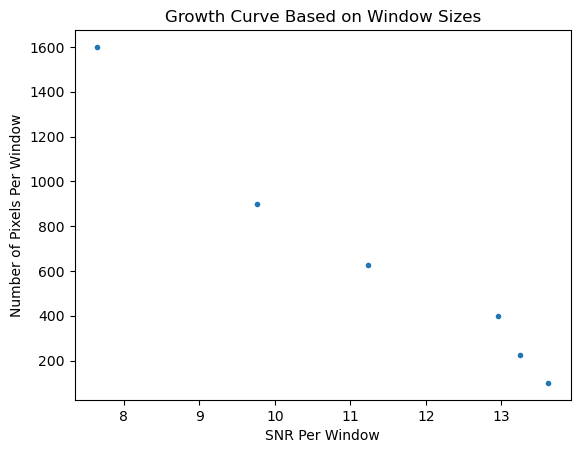

In [260]:
#window: 10, 15, 20, 25, 30, 40
SNR_tests = [13.621575917348132, 13.241618624810863, 12.956436373957658, 11.23555022282256, 9.76546117063015, 7.647712565723518]
n_pixels_test = [100, 225, 400, 625, 900, 1600]

plt.plot(SNR_tests, n_pixels_test, '.')
plt.ylabel('Number of Pixels Per Window')
plt.xlabel('SNR Per Window')
plt.title('Growth Curve Based on Window Sizes')


In [200]:
#photometry on standards, not sure if i can do it correctly with a for loop or else i would 
models_sts = []
flux_sts = []

peaks_st_1 = finding_peaks(data_list[0], 30000)    
centx_st1, centy_st1, cut_st1 = find_centroid(data_list[0], 299, 296)
sigx_st1, sigy_st1 = find_moment(data_list[0], 299, 296, centx_st1, centy_st1)
mod_st1, conv_st1, flux_st1, cutout_st1, g_st1, window_st1 = phot(data_list[0], 299, 296, centx_st1, centy_st1, sigx_st1, sigy_st1)

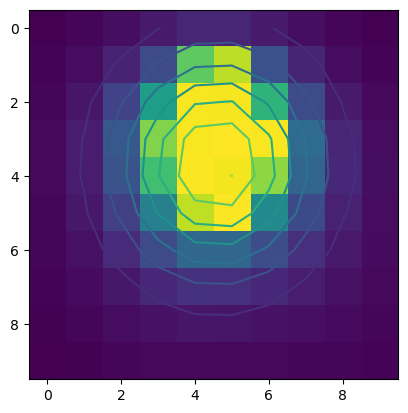

In [201]:
models_sts.append(mod_st1)
flux_sts.append(flux_st1)

plt.imshow(cutout_st1)
plt.contour(mod_st1)

In [176]:
peaks_st2 = finding_peaks(data_list[1], 30000)
centx_st2, centy_st2, cut_st2 = find_centroid(data_list[1], 297, 296)
sigx_st2, sigy_st2 = find_moment(data_list[1], 297, 296, centx_st2, centy_st2)
mod_st2, conv_st2, flux_st2, cutout_st2, g_st2, window_st2 = phot(data_list[1], 297, 296, centx_st2, centy_st2, sigx_st2, sigy_st2)

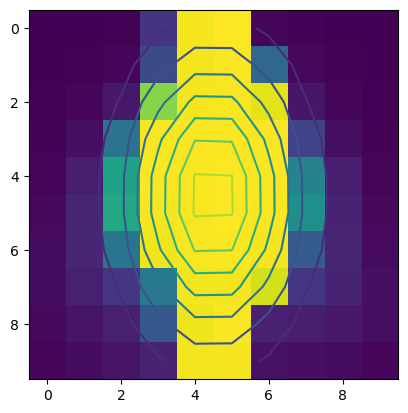

In [202]:
models_sts.append(mod_st2)
flux_sts.append(flux_st2)

plt.imshow(cutout_st2)
plt.contour(mod_st2)

In [180]:
peaks_st3 = finding_peaks(data_list[2], 30000)
centx_st3, centy_st3, cut_st3 = find_centroid(data_list[2], 296, 297)
sigx_st3, sigy_st3 = find_moment(data_list[2], 296, 297, centx_st3, centy_st3)
mod_st3, conv_st3, flux_st3, cutout_st3, g_st3, window_st3 = phot(data_list[2], 296, 297, centx_st3, centy_st3, sigx_st3, sigy_st3)

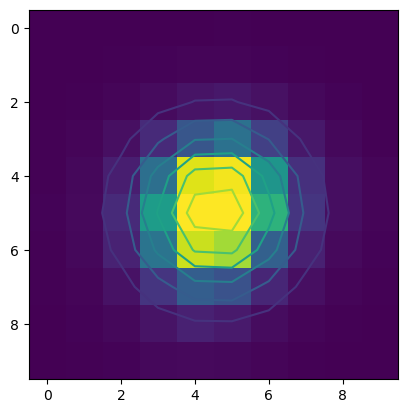

In [203]:
models_sts.append(mod_st3)
flux_sts.append(flux_st3)

plt.imshow(cutout_st3)
plt.contour(mod_st3)

In [186]:
peaks_st4 = finding_peaks(data_list[3], 50000)
centx_st4, centy_st4, cut_st4 = find_centroid(data_list[3], 296, 297)
sigx_st4, sigy_st4 = find_moment(data_list[3], 296, 297, centx_st4, centy_st4)
mod_st4, conv_st4, flux_st4, cutout_st4, g_st4, window_st4 = phot(data_list[3], 296, 297, centx_st4, centy_st4, sigx_st4, sigy_st4)

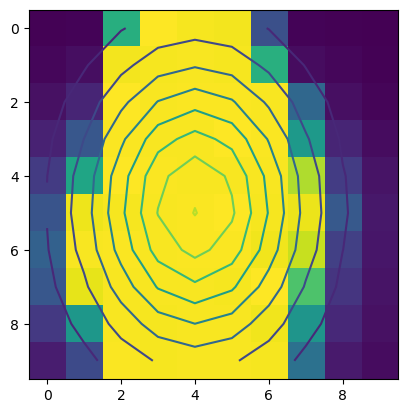

In [204]:
models_sts.append(mod_st4)
flux_sts.append(flux_st4)

plt.imshow(cutout_st4)
plt.contour(mod_st4)

In [191]:
peaks_st5 = finding_peaks(data_list[4], 30000)
centx_st5, centy_st5, cut_st5 = find_centroid(data_list[4], 304, 292)
sigx_st5, sigy_st5 = find_moment(data_list[4], 304, 292, centx_st5, centy_st5)
mod_st5, conv_st5, flux_st5, cutout_st5, g_st5, window_st5 = phot(data_list[4], 304, 292, centx_st5, centy_st5, sigx_st5, sigy_st5)

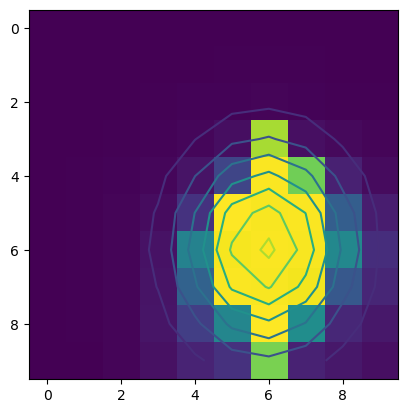

In [205]:
models_sts.append(mod_st5)
flux_sts.append(flux_st5)

plt.imshow(cutout_st5)
plt.contour(mod_st5)

In [210]:
window_sts = 10
known_g_mag = np.array([11.106956, 9.903633, 11.046957, 9.485024, 10.344067]) #used Gmag since not all had Vmag on simbad
inst_mag = np.array([])

for i in range(len(models_sts)):
    blank_sky = data_list[i][100 - int(window_sts/2): 100 + int(window_sts/2), 100 - int(window_sts/2): 100 + int(window_sts/2)]
    blank_x, blank_y = np.meshgrid(np.arange(100 - int(window_sts/2), 100 + int(window_sts/2)), 
                                np.arange(100 - int(window_sts/2), 100 + int(window_sts/2)))

    blank_convolve = blank_sky * models_sts[i]
    sts_sky = np.median(blank_convolve)
    sts_pixels = window_sts ** 2
    sts_tot_sky = sts_sky * sts_pixels
    sts_net_star = flux_sts[i] - sts_tot_sky 

    mag = -2.5 * np.log10(sts_net_star / exposure_time[i])
    inst_mag = np.append(inst_mag, mag)

In [216]:
m_diff = known_g_mag - inst_mag
airmass_sts = np.delete(airmasses, [5, 6])
m_diff, inst_mag

(array([18.75228343, 17.94934404, 18.63746773, 17.55854533, 18.18491087]),
 array([-7.64532743, -8.04571104, -7.59051073, -8.07352133, -7.84084387]))

In [267]:
def linear_model(x, A, B):
    return A + B * x

def find_unweighted_vals(x_array, y_array, num_vals):
    N = num_vals
    x_sum = np.sum(x_array)
    y_sum = np.sum(y_array)
    x_sq_sum = np.sum((x_array)**2)
    x_y_sum = np.sum(x_array * y_array)

    denom = N * x_sq_sum - (x_sum)**2

    #Find A:
    A = ((x_sq_sum * y_sum) - (x_sum * x_y_sum)) / denom

    #Find B:
    B = ((N * x_y_sum) - (x_sum * y_sum)) / denom


    #Finding Uncertainties:
    sum_meas_pred = np.sum((y_array - (A + B * x_array))**2)

    sigma_y = np.sqrt((1/(N-2)) * sum_meas_pred)

    sigma_A = sigma_y * np.sqrt(x_sq_sum / denom)
    sigma_B = sigma_y * np.sqrt(N / denom)

    return A, B, sigma_y, sigma_A, sigma_B

In [268]:
ZP, k, sigma_y, sigma_ZP, sigma_k = find_unweighted_vals(airmass_sts, m_diff, 5)

ZP, k, sigma_y, sigma_ZP, sigma_k

(17.991100002812615,
 0.15298647873706278,
 0.5651999880906545,
 1.2301287152318097,
 0.8170759802372743)

Text(0.5, 1.0, 'Linear Fit of Airmass vs. Magnitudes')

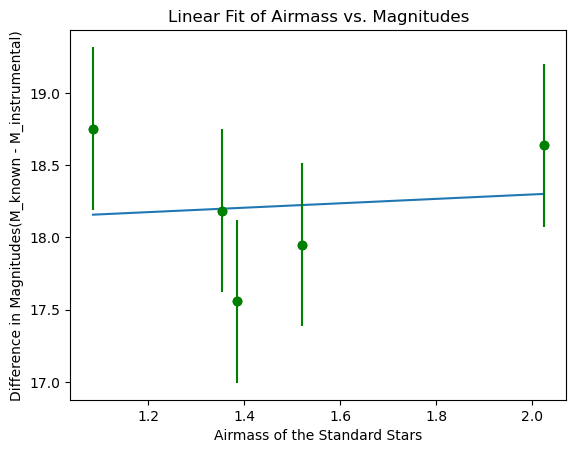

In [271]:
smooth_x = np.linspace(min(airmass_sts), max(airmass_sts), 100)
plt.scatter(airmass_sts, m_diff, color='green')
plt.plot(smooth_x, linear_model(smooth_x, ZP, k))
plt.errorbar(airmass_sts, m_diff, yerr=sigma_y, fmt='o', color='green')
plt.xlabel('Airmass of the Standard Stars')
plt.ylabel('Difference in Magnitudes(M_known - M_instrumental)')
plt.title('Linear Fit of Airmass vs. Magnitudes')

In [220]:
m_calibrated = (-2.5 * np.log10(n_net_star / header_list[5]['EXPOSURE'])) + ZP + (k * airmasses[5])
m_calibrated

10.236302849593748

In [231]:
peaks_sci_r = finding_peaks(data_list[6], 10000)
peaks_sci_r
centx_sci_r, centy_sci_r, cut_sci_r = find_centroid(data_list[6], 296, 296)
sigx_sci_r, sigy_sci_r = find_moment(data_list[6], 296, 296, centx_sci_r, centy_sci_r)
mod_sci_r, conv_sci_r, flux_sci_r, cutout_sci_r, g_sci_r, window_sci_r = phot(data_list[6], 296, 296, centx_sci_r, centy_sci_r, sigx_sci_r, sigy_sci_r)

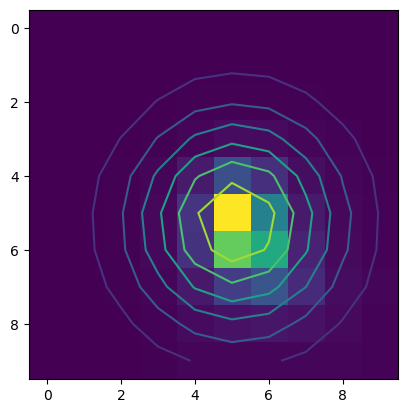

In [232]:
plt.imshow(cutout_sci_r)
plt.contour(mod_sci_r)

In [256]:
empty_sky_r = data_list[6][100 - int(window_sci_r/2): 100 + int(window_sci_r/2), 100 - int(window_sci_r/2): 100 + int(window_sci_r/2)]
empty_x_r, empty_y_r = np.meshgrid(np.arange(100 - int(window_sci_r/2), 100 + int(window_sci_r/2)), 
                                np.arange(100 - int(window_sci_r/2), 100 + int(window_sci_r/2)))

empty_convolve_r = empty_sky_r * mod_sci_r
n_sky_r = np.median(empty_convolve_r)
n_pixels_r = window_sci_r ** 2
n_tot_sky_r= n_sky_r * n_pixels_r
n_net_star_r = flux_sci_r - n_tot_sky_r

snr_r = n_net_star_r / (np.sqrt((avg_gain * n_net_star_r) + (n_pixels_r * avg_gain * n_sky_r) + (n_pixels_r * (avg_noise**2))))
snr_r, n_net_star_r, flux_sci_r, n_tot_sky_r, window_sci_r, n_sky_r, n_pixels_r

(24.4061203186133,
 5096.66498224557,
 5487.10319683041,
 390.43821458483956,
 10,
 3.9043821458483956,
 100)

In [258]:
inst_mag_r = -2.5 * np.log10(n_net_star_r / exposure_time[6])
inst_mag_g = -2.5 * np.log10(n_net_star/ exposure_time[5])

color_index = inst_mag_g - inst_mag_r
color_index

0.8383910749642167

In [272]:
inst_mag_g, inst_mag_r

(-4.737021006138199, -5.5754120811024155)